In [1]:
# from gensim import corpora, models, similarities
# from collections import defaultdict
# from pprint import pprint
# from openpyxl import Workbook, load_workbook

# wb = load_workbook(filename = 'data/GICS_map2014.xlsx')
# sheet_list = wb['Descriptions']
# file_ob = open("Description.txt",'a')
# for i in range(6,346,2):
#     s = 'H' + str(i)
#     s1 = 'H' + str(i+1)
#     print(sheet_list[s].value + ": " + sheet_list[s1].value) 
#     file_ob.write(sheet_list[s].value + ": " + sheet_list[s1].value + "\n")
# file_ob.close()

file2 = open("Description.txt",'r')
docs = file2.read().split("\n")
print len(docs)

171


In [2]:
import os
import shutil
src_files = os.listdir("old_data/CompanyPages/")
i=0
listfinal = []
for file_name in src_files:
    full_file_name = os.path.join("old_data/CompanyPages/", file_name)
    file_ob = open(full_file_name,'r')
    listfinal.insert(i,file_ob.read().replace("\n"," ").replace("==","").lower().decode(encoding='UTF-8',errors='ignore'))
    i=i+1
    file_ob.close()
del listfinal[0]   

In [ ]:
# from spacy.en import English
# import spacy
# texts = listfinal
# en_nlp = spacy.load('en')
# bad_deps = ('amod', 'compound')
# nlp = English()
# merge = True
# for row, doc in enumerate(nlp.pipe(texts)):
#     if merge:
#         # from the spaCy blog, an example on how to merge
#         # noun phrases into single tokens
#         for phrase in list(doc.noun_chunks):
#             # Only keep adjectives and nouns, e.g. "good ideas"
#             while len(phrase)>1 and phrase.dep[_ not in bad_deps:
#                 phrase = phrase[1:]
#                 print phrase
#             if len(phrase) > 1:
#                 # Merge the tokens, e.g. good_ideas
#                 phrase.merge(phrase.root.tag_, phrase.text,
#                      phrase.root.ent_type_)


In [2]:
#Preprocess

import pickle
import numpy as np
import spacy
from lda2vec import preprocess, Corpus
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import string

en_nlp = spacy.load('en')
texts = docs

# Remove tokens with these substrings
bad = ["-----", "---", "...", "“", "”", "'ve","^^^","ax>", '`@("','==', '===', '^^^',"    ","   ","  "]
SYMBOLS = " ".join(string.punctuation).split(" ")

STOPLIST = set(["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS) + ['s', 't', 'just', 'don', 'd', 'llm', 'o', 're', 've', 'y', 'ain', 'aren', 
                                                                       'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 
                                                                       'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn']) 



def clean(line):
      line  = ''.join(ch for ch in line if  ch.isdigit()==False)
      line  = ' '.join(w for w in line.split(' ') if w not in bad)
#     line  = ''.join(ch for ch in line if ch not in SYMBOLS)
#     line  = ' '.join(w for w in line.split(' ') if w not in STOPLIST)
      return line


# Preprocess data
                    
max_length = 500   # Limit of 10k words per document
# Convert to unicode (spaCy only works with unicode)
texts = [unicode(clean(d)) for d in texts]
                    
tokens, vocab = preprocess.tokenize(texts, max_length, merge=True,n_threads=4) 
# try merge = True for getting phrases as tokens

print "Tokenization complete..."
corpus = Corpus()

# Make a ranked list of rare vs frequent words over entire corpus
corpus.update_word_count(tokens)
corpus.finalize()

# The tokenization uses spaCy indices, and so may have gaps
# between indices for words that aren't present in our dataset.
# This builds a new compact index
compact = corpus.to_compact(tokens)

# Remove extremely rare words
pruned = corpus.filter_count(compact, min_count=1)

# Convert the compactified arrays into bag of words arrays
bow = corpus.compact_to_bow(compact)

# Words tend to have power law frequency, so selectively
# downsample the most prevalent words
clean = corpus.subsample_frequent(bow)

# Now flatten a 2D array of document per row and word position
# per column to a 1D array of words. This will also remove skips
# and OoV words
doc_ids = np.arange(pruned.shape[0])
flattened, (doc_ids,) = corpus.compact_to_flat(compact, doc_ids)
assert flattened.min() >= 0

# Fill in the pretrained word vectors
fn_wordvc = 'old_data/GoogleNews-vectors-negative300.bin'
vectors, s, f = corpus.compact_word_vectors(vocab, filename=fn_wordvc)

# Save all of the preprocessed files 
pickle.dump(vocab, open('sec_vocab.pkl', 'w'))
pickle.dump(corpus, open('sec_corpus.pkl', 'w'))

np.save("sec_flattened", flattened)
np.save("sec_doc_ids", doc_ids)
np.save("sec_pruned", pruned)
np.save("sec_bow", bow)
np.save("sec_vectors", vectors)

Tokenization complete...
[[   1717 1242811    2064 ...,      -2      -2      -2]
 [   1717 1242811    2064 ...,      -2      -2      -2]
 [1510252     420    7934 ...,      -2      -2      -2]
 ..., 
 [    943   11665     420 ...,      -2      -2      -2]
 [1510718     420    1573 ...,      -2      -2      -2]
 [     -2      -2      -2 ...,      -2      -2      -2]]
[     -2      -1      -2 ...,    1006 1510567    8637]
[   0    1    2 ..., 1029 1030 1031]
3 ,  -->  上
4 .  -->  上
6 :  -->  上
23 -  -->  上
87 )  -->  上
88 (  -->  上


In [3]:
print tokens
print compact
print pruned
print bow
print clean
print s,f
print vectors

[[   1717 1242811    2064 ...,      -2      -2      -2]
 [   1717 1242811    2064 ...,      -2      -2      -2]
 [1510252     420    7934 ...,      -2      -2      -2]
 ..., 
 [    943   11665     420 ...,      -2      -2      -2]
 [1510718     420    1573 ...,      -2      -2      -2]
 [     -2      -2      -2 ...,      -2      -2      -2]]
[[ 46  17  49 ...,   0   0   0]
 [ 46  17  49 ...,   0   0   0]
 [835   6 671 ...,   0   0   0]
 ..., 
 [164 196   6 ...,   0   0   0]
 [539   6   8 ...,   0   0   0]
 [  0   0   0 ...,   0   0   0]]
[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]]
[[481   0   0 ...,   0   0   0]
 [463   0   0 ...,   0   0   0]
 [466   0   0 ...,   0   0   0]
 ..., 
 [479   0   0 ...,   0   0   0]
 [452   0   0 ...,   0   0   0]
 [500   0   0 ...,   0   0   0]]
[[481   0   0 ...,   0   0   0]
 [463   0   0 ...,   0   0   0]
 [466   0   0 ...,   0   0   0]
 ..., 
 [479   0   0 ...,   0   

In [1]:
#LDA2VEC MODEL

from lda2vec import EmbedMixture
from lda2vec import dirichlet_likelihood
from lda2vec.utils import move

from chainer import Chain
import chainer.links as L
import chainer.functions as F

import numpy as np


class LDA2Vec(Chain):
    def __init__(self, n_documents=100, n_document_topics=10,
                 n_units=256, n_vocab=1000, dropout_ratio=0.5, train=True,
                 counts=None, n_samples=15, word_dropout_ratio=0.0,
                 power=0.75, temperature=1.0):
        em = EmbedMixture(n_documents, n_document_topics, n_units,
                          dropout_ratio=dropout_ratio, temperature=temperature)
        kwargs = {}
        kwargs['mixture'] = em
        kwargs['sampler'] = L.NegativeSampling(n_units, counts, n_samples,
                                               power=power)
        super(LDA2Vec, self).__init__(**kwargs)
        rand = np.random.random(self.sampler.W.data.shape)
        self.sampler.W.data[:, :] = rand[:, :]
        self.n_units = n_units
        self.train = train
        self.dropout_ratio = dropout_ratio
        self.word_dropout_ratio = word_dropout_ratio
        self.n_samples = n_samples

    def prior(self):
        dl1 = dirichlet_likelihood(self.mixture.weights)
        return dl1

    def fit_partial(self, rdoc_ids, rword_indices, window=5,
                    update_only_docs=False):
        doc_ids, word_indices = move(self.xp, rdoc_ids, rword_indices)
        pivot_idx = next(move(self.xp, rword_indices[window: -window]))
        pivot = F.embed_id(pivot_idx, self.sampler.W)
        if update_only_docs:
            pivot.unchain_backward()
        doc_at_pivot = rdoc_ids[window: -window]
        doc = self.mixture(next(move(self.xp, doc_at_pivot)),
                           update_only_docs=update_only_docs)
        loss = 0.0
        start, end = window, rword_indices.shape[0] - window
        context = (F.dropout(doc, self.dropout_ratio) +
                   F.dropout(pivot, self.dropout_ratio))
        for frame in range(-window, window + 1):
            # Skip predicting the current pivot
            if frame == 0:
                continue
            # Predict word given context and pivot word
            # The target starts before the pivot
            targetidx = rword_indices[start + frame: end + frame]
            doc_at_target = rdoc_ids[start + frame: end + frame]
            doc_is_same = doc_at_target == doc_at_pivot
            rand = np.random.uniform(0, 1, doc_is_same.shape[0])
            mask = (rand > self.word_dropout_ratio).astype('bool')
            weight = np.logical_and(doc_is_same, mask).astype('int32')
            # If weight is 1.0 then targetidx
            # If weight is 0.0 then -1
            targetidx = targetidx * weight + -1 * (1 - weight)
            target, = move(self.xp, targetidx)
            loss = self.sampler(context, target)
            loss.backward()
            if update_only_docs:
                # Wipe out any gradient accumulation on word vectors
                self.sampler.W.grad *= 0.0
        return loss.data


In [ ]:
#RUN MODEL

import os
import os.path
import pickle
import time
import shelve
import unicodedata

import chainer
from chainer import cuda
from chainer import serializers
import chainer.optimizers as O
import numpy as np

from lda2vec import utils
from lda2vec import prepare_topics, print_top_words_per_topic, topic_coherence

gpu_id = int(os.getenv('CUDA_GPU', 0))
cuda.get_device(gpu_id).use()
print "Using GPU " + str(gpu_id)

data_dir = os.getenv('data_dir', 'sectorData')
fn_vocab = '{data_dir:s}/sec_vocab.pkl'.format(data_dir=data_dir)
fn_corpus = '{data_dir:s}/sec_corpus.pkl'.format(data_dir=data_dir)
fn_flatnd = '{data_dir:s}/sec_flattened.npy'.format(data_dir=data_dir)
fn_docids = '{data_dir:s}/sec_doc_ids.npy'.format(data_dir=data_dir)
fn_vectors = '{data_dir:s}/sec_vectors.npy'.format(data_dir=data_dir)
vocab = pickle.load(open(fn_vocab, 'r'))
corpus = pickle.load(open(fn_corpus, 'r'))
flattened = np.load(fn_flatnd)
doc_ids = np.load(fn_docids)
vectors = np.load(fn_vectors)
# vectors = np.delete(vectors,77743,0)
# Model Parameters
# Number of documents
n_docs = doc_ids.max() + 1
# Number of unique words in the vocabulary
n_vocab = flattened.max()  + 1
# 'Strength' of the dircihlet prior; 200.0 seems to work well
clambda = 200.0
# Number of topics to fit
n_topics = int(os.getenv('n_topics', 171))
batchsize = 4096
# Power for neg sampling
power = float(os.getenv('power', 0.75))
# Intialize with pretrained word vectors
pretrained = bool(int(os.getenv('pretrained', True)))
# Sampling temperature
temperature = float(os.getenv('temperature', 1.0))
# Number of dimensions in a single word vector
n_units = int(os.getenv('n_units', 300))
# Get the string representation for every compact key
words = corpus.word_list(vocab)[:n_vocab]
# How many tokens are in each document
doc_idx, lengths = np.unique(doc_ids, return_counts=True)
doc_lengths = np.zeros(doc_ids.max() + 1, dtype='int32')
doc_lengths[doc_idx] = lengths
# Count all token frequencies
tok_idx, freq = np.unique(flattened, return_counts=True)
term_frequency = np.zeros(n_vocab, dtype='int32')
term_frequency[tok_idx] = freq

for key in sorted(locals().keys()):
    val = locals()[key]
    val = unicodedata.normalize('NFKD', unicode(val)).encode('ascii','ignore')
    if len(val) < 100 and '<' not in val:
        print key, val

model = LDA2Vec(n_documents=n_docs, n_document_topics=n_topics,
                n_units=n_units, n_vocab=n_vocab, counts=term_frequency,
                n_samples=15, power=power, temperature=temperature)
if os.path.exists('sec_lda2vec.hdf5'):
    print "Reloading from saved"
    serializers.load_hdf5("sec_lda2vec.hdf5", model)

vectors = np.resize(vectors,(1032,300))
if pretrained:
    model.sampler.W.data[:, :] = vectors[:n_vocab, :]
model.to_gpu()
optimizer = O.Adam()
optimizer.setup(model)
clip = chainer.optimizer.GradientClipping(5.0)
optimizer.add_hook(clip)

# print model.sampler.W.data.shape[0]
# print len(words)
j = 0
epoch = 0
fraction = batchsize * 1.0 / flattened.shape[0]
progress = shelve.open('sec_progress.shelve')
for epoch in range(200):
    data = prepare_topics(cuda.to_cpu(model.mixture.weights.W.data).copy(),
                          cuda.to_cpu(model.mixture.factors.W.data).copy(),
                          cuda.to_cpu(model.sampler.W.data).copy(),
                          words)
    top_words = print_top_words_per_topic(data)
    if j % 100 == 0 and j > 100:
        coherence = topic_coherence(top_words)
        for j in range(n_topics):
            print j, coherence[(j, 'cv')]
        kw = dict(top_words=top_words, coherence=coherence, epoch=epoch)
        progress[str(epoch)] = pickle.dumps(kw)
    data['doc_lengths'] = doc_lengths
    data['term_frequency'] = term_frequency
    np.savez('sec_topics.pyldavis', **data)
    for d, f in utils.chunks(batchsize, doc_ids, flattened):
        t0 = time.time()
        optimizer.zero_grads()
        l = model.fit_partial(d.copy(), f.copy())
        prior = model.prior()
        loss = prior * fraction
        loss.backward()
        optimizer.update()
        msg = ("J:{j:05d} E:{epoch:05d} L:{loss:1.3e} "
               "P:{prior:1.3e} R:{rate:1.3e}")
        prior.to_cpu()
        loss.to_cpu()
        t1 = time.time()
        dt = t1 - t0
        rate = batchsize / dt
        logs = dict(loss=float(l), epoch=epoch, j=j,
                    prior=float(prior.data), rate=rate)
#         print msg.format(**logs)
        j += 1
    serializers.save_hdf5("sec_lda2vec.hdf5", model)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

try:
    import seaborn
except:
    pass

import pyLDAvis
pyLDAvis.enable_notebook()
npz = np.load(open('sec_topics.pyldavis.npz', 'r'))
dat = {k: v for (k, v) in npz.iteritems()}
dat['vocab'] = dat['vocab'].tolist()

top_n = 10
topic_to_topwords = {}
for j, topic_to_word in enumerate(dat['topic_term_dists']):
    top = np.argsort(topic_to_word)[::-1][:top_n]
    msg = 'Topic %i '  % j
    top_words = [dat['vocab'][i].strip()[:35] for i in top]
    if 'out_of_vocabulary' in top_words: top_words.remove('out_of_vocabulary')
    if '<Padded>' in top_words: top_words.remove('<Padded>')
    msg += ' '.join(top_words)
    print msg
    topic_to_topwords[j] = top_words

Topic 0 out_of_vocabulary , and of electronic manufacturers equipment semiconductors
Topic 1 out_of_vocabulary and , both of in . the
Topic 2 out_of_vocabulary and of , equipment manufacturers semiconductors both
Topic 3 out_of_vocabulary and of , both . in the
Topic 4 out_of_vocabulary and , of electricity both integrated energy merchants cellular
Topic 5 out_of_vocabulary and both , of in . cellular
Topic 6 out_of_vocabulary and , of both . in semiconductors
Topic 7 out_of_vocabulary , and of semiconductors both . integrated energy merchants
Topic 8 out_of_vocabulary and , of both in . the
Topic 9 out_of_vocabulary and , of both equipment . in
Topic 10 out_of_vocabulary and , of semiconductors . electronic both
Topic 11 out_of_vocabulary , and of electronic semiconductors . peripherals
Topic 12 out_of_vocabulary , and of semiconductors cellular electronic .
Topic 13 out_of_vocabulary , and of both electronic . semiconductors
Topic 14 out_of_vocabulary , and semiconductors of electron

In [2]:
import warnings
warnings.filterwarnings('ignore')
prepared_data = pyLDAvis.prepare(dat['topic_term_dists'], dat['doc_topic_dists'], 
                                 dat['doc_lengths'] * 1.0, dat['vocab'], dat['term_frequency'] * 1.0, mds='tsne')
pyLDAvis.display(prepared_data)

In [4]:
msg = "{weight:02d}% in topic {topic_id:02d} which has top words {text:s}"
sector_weight = [0]*170
for topic_id, weight in enumerate(dat['doc_topic_dists'][0]):
    if weight > 0.03:
        text = u', '.join(topic_to_topwords[topic_id]).encode('utf-8').strip()
        i=0
        for sector in texts:
            for c in sector:
                if c in text:
                    sector_weight[i]=sector_weight[i]+1  
            i = i+1
        print msg.format(topic_id=topic_id, weight=int(weight * 100.0), text=text)
print sector_weight
print "Sector: " + ' '.join(texts[sector_weight.index(max(sector_weight))]).title()
    

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


NameError: name 'texts' is not defined

In [5]:
msg = "{weight:02d}% in topic {topic_id:02d} which has top words {text:s}"
for topic_id, weight in enumerate(dat['doc_topic_dists'][50]):
    if weight > 0:
        text = u', '.join(topic_to_topwords[topic_id]).encode('utf-8').strip()
        print msg.format(topic_id=topic_id, weight=int(weight * 100.0), text=text)

00% in topic 00 which has top words out_of_vocabulary, ,, and, of, electronic, manufacturers, equipment, semiconductors
00% in topic 01 which has top words out_of_vocabulary, and, ,, both, of, in, ., the
00% in topic 02 which has top words out_of_vocabulary, and, of, ,, equipment, manufacturers, semiconductors, both
00% in topic 03 which has top words out_of_vocabulary, and, of, ,, both, ., in, the
00% in topic 04 which has top words out_of_vocabulary, and, ,, of, electricity, both, integrated energy merchants, cellular
00% in topic 05 which has top words out_of_vocabulary, and, both, ,, of, in, ., cellular
00% in topic 06 which has top words out_of_vocabulary, and, ,, of, both, ., in, semiconductors
00% in topic 07 which has top words out_of_vocabulary, ,, and, of, semiconductors, both, ., integrated energy merchants
00% in topic 08 which has top words out_of_vocabulary, and, ,, of, both, in, ., the
00% in topic 09 which has top words out_of_vocabulary, and, ,, of, both, equipment, .,

<Container object of 171 artists>

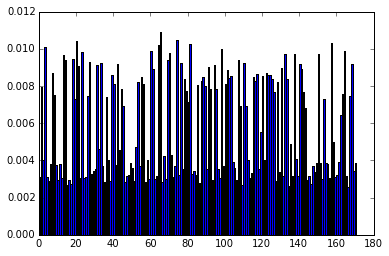

In [6]:
plt.bar(np.arange(171), dat['doc_topic_dists'][1])

In [ ]:
from openpyxl import Workbook, load_workbook
#pyLDAvis.enable_notebook()

wb = load_workbook(filename = 'data/GICS_map2014.xlsx')
sheet_list = wb['Descriptions']
file_ob = open("Description.txt",'a')
for i in range(6,346,2):
    s = 'H' + str(i)
    s1 = 'H' + str(i+1)
    print(sheet_list[s].value + ": " + sheet_list[s1].value) 
    file_ob.write(sheet_list[s].value + ": " + sheet_list[s1].value + "\n")
file_ob.close()


In [4]:
sector_dict = {}

with open("Description.txt") as f:
    content = f.readlines()
    for line in content:
        div = line.split(": ",1)
        sector_dict[div[0].lower()] = div[1].replace("\n","")
        
print len(sector_dict)

170


In [5]:

# dictionary = corpora.Dictionary(texts)
# dictionary.save('sector.dict')
# # print(dictionary.token2id)
# corpus = [dictionary.doc2bow(text) for text in texts]
# corpora.MmCorpus.serialize('corpus.mm', corpus) # store to disk, for later use
# # print(corpus)
# lsi = models.lsimodel.LsiModel(corpus=corpus, id2word=dictionary, num_topics=170)
# lsi.print_topics(10)
# lda = models.ldamodel.LdaModel(corpus, num_topics=170)
# for i in lda.show_topics(len(dictionary)):
#     print i
# print dictionary.id2word(3)

[['oil',
  'gas',
  'drilling',
  'or',
  'owners',
  'drilling',
  'rigs',
  'that',
  'contract',
  'their',
  'services',
  'drilling'],
 ['oil',
  'gas',
  'equipment',
  'services:',
  'manufacturers',
  'equipment,',
  'including',
  'drilling',
  'rigs',
  'equipment,',
  'providers',
  'supplies',
  'services',
  'companies',
  'involved',
  'oil',
  'gas'],
 ['integrated',
  'oil',
  'integrated',
  'oil',
  'companies',
  'engaged',
  'exploration',
  'production',
  'oil',
  'as',
  'well',
  'as',
  'at',
  'least',
  'other',
  'significant',
  'activity',
  'either',
  'marketing',
  'transportation,',
  'or',
  'chemicals.'],
 ['oil',
  'gas',
  'exploration',
  'companies',
  'engaged',
  'exploration',
  'production',
  'oil',
  'gas',
  'not',
  'classified',
  'elsewhere.'],
 ['oil',
  'gas',
  'refining',
  'companies',
  'engaged',
  'refining',
  'marketing',
  'oil,',
  'gas',
  'and/or',
  'refined',
  'products',
  'not',
  'classified',
  'integrated',
  'oil'

/home/malaviyac/lda2vec/env/lib/python2.7/site-packages/numpy-1.11.1rc1-py2.7-linux-x86_64.egg/numpy/lib/utils.py:99: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  warnings.warn(depdoc, DeprecationWarning)
/usr/lib64/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/usr/lib64/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/usr/lib64/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/usr/lib64/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  Depre